In [8]:
import pandas_datareader as web
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize
from scipy.stats import norm
import numpy_financial as npf
import requests

In [9]:
def generate_df(file_name):
    df = pd.read_csv(f"./data/coincodex2/{file_name}")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    df = df.iloc[::-1]
    df = df[df.index >= datetime(2020,12,1)]
    df.head()
    return df


def calculate_allocation(index,coin_allocation,coin,input_df):
    principal_usd = 1000000
    input_df[f'{coin}_ALLOC'] = coin_allocation
    input_df[f'{coin}_NET_ALLOC_USD'] = (input_df[f'{coin}_ALLOC'] * principal_usd)  
    input_df[f'{coin}_INIT_AMNT'] = round(input_df[f'{coin}_NET_ALLOC_USD'] / float(input_df[f'{coin}'].iloc[0]),2)
    input_df[f'{coin}_AMNT'] = input_df[f'{coin}_INIT_AMNT']
    input_df[f'{coin}_NET'] = round(input_df[f'{coin}_INIT_AMNT'] * input_df[f'{coin}'],2)

def add_day_count(input_df):
    input_df['NET'] = 0
    input_df['Day_Count'] = 1
    input_df['Day_Count_Cum'] = input_df['Day_Count'].cumsum()

def convert_yield_to_daily(annual_yield):
    ANNUAL_YIELD_PERCENTAGE = annual_yield / 100
    DAILY_YIELD_PERCENTAGE = (1 + ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
    return DAILY_YIELD_PERCENTAGE

def assign_daily_rate(coin,annual_yield,input_df):
    input_df[f'{coin}_Daily_Rate'] = convert_yield_to_daily(annual_yield)
    
def calculate_yield(annual_yield,input_df,coin):
    ANNUAL_YIELD_PERCENTAGE = annual_yield / 100
    DAILY_YIELD_PERCENTAGE = (1 + ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
    INITIAL_DAILY_YIELD_AMNT = input_df[f'{coin}_INIT_AMNT'] * DAILY_YIELD_PERCENTAGE
    input_df[f'{coin}_Daily_Rate'] = DAILY_YIELD_PERCENTAGE
    input_df[f'{coin}_AMNT_YIELD'] = input_df[f'{coin}_AMNT'] * (1 + DAILY_YIELD_PERCENTAGE) ** (input_df['Day_Count_Cum'])
    input_df[f'{coin}_NET_YIELD'] = round(input_df[f'{coin}_AMNT_YIELD'] * input_df[f"{coin}"],2)

def re_calculate_yield(input_df,coin):
    input_df[f'{coin}_AMNT_YIELD'] = input_df[f'{coin}_AMNT'] * (1 + input_df[f'{coin}_Daily_Rate']) ** (input_df['Day_Count_Cum'])
    input_df[f'{coin}_NET_YIELD'] = round(input_df[f'{coin}_AMNT_YIELD'] * input_df[f"{coin}"],2)
    
def plot_df(input_df,title,columns=[]):
    pl = input_df.plot(y=columns,figsize=(16,8),title=title)
    # after plotting the data, format the labels
    current_values = pl.get_yticks()
    # using format string '{:.0f}' here but you can choose others
    pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

In [10]:
eth_df = generate_df("ethereum_2020-12-1_2022-5-10.csv")
sol_df = generate_df("solana_2020-12-1_2022-5-10.csv")
near_df = generate_df("near-protocol_2020-12-1_2022-5-10.csv")
avax_df = generate_df("avalanche_2020-12-1_2022-5-10 (1).csv")
ftm_df = generate_df("fantom_2020-12-1_2022-5-10.csv")



In [ ]:
#dynamic data sets

In [11]:
principal_usd = 100000
psg_staking_coins = ['ETH','SOL','AVAX','NEAR','FTM']


psg_staking_portfolio_df = pd.concat([eth_df['Close'],sol_df['Close'], avax_df['Close'], near_df['Close'],ftm_df['Close']],axis=1)
psg_staking_portfolio_df.columns = psg_staking_coins

for i in range(0,len(psg_staking_coins)):
    calculate_allocation(i,psg_staking_coins_allocations[i],psg_staking_coins[i],psg_staking_portfolio_df)
    
psg_staking_portfolio_df.fillna(0,inplace=True)
psg_staking_portfolio_df['NET'] = psg_staking_portfolio_df['ETH_NET']  + psg_staking_portfolio_df['SOL_NET'] + psg_staking_portfolio_df['AVAX_NET'] + psg_staking_portfolio_df['NEAR_NET'] + psg_staking_portfolio_df['FTM_NET']

psg_staking_portfolio_df

,ETH,SOL,AVAX,NEAR,FTM,ETH_ALLOC,ETH_NET_ALLOC_USD,ETH_INIT_AMNT,ETH_AMNT,ETH_NET,...,NEAR_NET_ALLOC_USD,NEAR_INIT_AMNT,NEAR_AMNT,NEAR_NET,FTM_ALLOC,FTM_NET_ALLOC_USD,FTM_INIT_AMNT,FTM_AMNT,FTM_NET,NET
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539,0.5,500000.0,847.72,847.72,499997.52,...,100000.0,92976.93,92976.93,99999.99,0.1,100000.0,4868747.1,4868747.1,100000.00,999997.52
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646,0.5,500000.0,847.72,847.72,507239.41,...,100000.0,92976.93,92976.93,109373.63,0.1,100000.0,4868747.1,4868747.1,110259.74,1044212.31
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888,0.5,500000.0,847.72,847.72,522962.58,...,100000.0,92976.93,92976.93,107414.99,0.1,100000.0,4868747.1,4868747.1,111437.61,1061185.57
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042,0.5,500000.0,847.72,847.72,484877.47,...,100000.0,92976.93,92976.93,102909.41,0.1,100000.0,4868747.1,4868747.1,102449.37,980259.92
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497,0.5,500000.0,847.72,847.72,504858.38,...,100000.0,92976.93,92976.93,103321.61,0.1,100000.0,4868747.1,4868747.1,109532.78,1019974.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065,0.5,500000.0,847.72,847.72,2288695.82,...,100000.0,92976.93,92976.93,1004318.20,0.1,100000.0,4868747.1,4868747.1,3535025.69,15438848.61
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732,0.5,500000.0,847.72,847.72,2242156.50,...,100000.0,92976.93,92976.93,973635.82,0.1,100000.0,4868747.1,4868747.1,3338655.77,14877595.20
2022-05-08,2513.908346,74.977144,51.193573,11.126441,0.672103,0.5,500000.0,847.72,847.72,2131090.38,...,100000.0,92976.93,92976.93,1034502.28,0.1,100000.0,4868747.1,4868747.1,3272301.68,14272334.78


In [211]:
principal_usd = 100000
coins = ['ETH','SOL','AVAX','NEAR','FTM']
psg_staking_coins_allocations_2021 = [0.50,0.15,0.15,0.10,0.10]
psg_staking_coins_allocations_2022 = [0.80,0.05,0.05,0.05,0.05]
#psg_staking_coins_allocations_2022 = [0.10,0.60,0.10,0.1,0.1]
psg_staking_coins_yields_2021=[8.00,5.75,9.39,10.00,14.19]
psg_staking_coins_yields_2022=[18.00,7.0,7.0,7.0,12.0]


In [212]:

eth_df = generate_df("ethereum_2020-12-1_2022-5-10.csv")
sol_df = generate_df("solana_2020-12-1_2022-5-10.csv")
avax_df = generate_df("avalanche_2020-12-1_2022-5-10.csv")
near_df = generate_df("near-protocol_2020-12-1_2022-5-10.csv")
ftm_df = generate_df("fantom_2020-12-1_2022-5-10.csv")
basket_portfolio_df = pd.concat([eth_df['Close'],sol_df['Close'],avax_df['Close'],near_df['Close'],ftm_df['Close']],axis=1)
basket_portfolio_df.columns = coins
basket_portfolio_df

,ETH,SOL,AVAX,NEAR,FTM
Date,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497
...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,11.239600,0.743458
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732


In [213]:
basket_portfolio_df_2021 = basket_portfolio_df[basket_portfolio_df.index < datetime(2022,1,1)].copy()

ETH_ALLOC = psg_staking_coins_allocations_2021[0]
ETH_NET_ALLOC_USD = (ETH_ALLOC * principal_usd)
ETH_INIT_AMNT = round(ETH_NET_ALLOC_USD / float(basket_portfolio_df_2021['ETH'].iloc[0]),2)
basket_portfolio_df_2021['ETH_AMNT'] = ETH_INIT_AMNT
basket_portfolio_df_2021['ETH_NET'] = round(ETH_INIT_AMNT * basket_portfolio_df_2021['ETH'],2)

SOL_ALLOC = psg_staking_coins_allocations_2021[1]
SOL_NET_ALLOC = (SOL_ALLOC * principal_usd)
SOL_INIT_AMNT = round(SOL_NET_ALLOC / float(basket_portfolio_df_2021['SOL'].iloc[0]))
basket_portfolio_df_2021['SOL_AMNT'] = SOL_INIT_AMNT
basket_portfolio_df_2021['SOL_NET'] = round(SOL_INIT_AMNT * basket_portfolio_df_2021['SOL'],2)

AVAX_ALLOC = psg_staking_coins_allocations_2021[2]
AVAX_NET_ALLOC = (AVAX_ALLOC * principal_usd)
AVAX_INIT_AMNT = round(AVAX_NET_ALLOC / float(basket_portfolio_df_2021['AVAX'].iloc[0]))
basket_portfolio_df_2021['AVAX_AMNT'] = AVAX_INIT_AMNT
basket_portfolio_df_2021['AVAX_NET'] = round(AVAX_INIT_AMNT * basket_portfolio_df_2021['AVAX'],2)


NEAR_ALLOC = psg_staking_coins_allocations_2021[3]
NEAR_NET_ALLOC = (NEAR_ALLOC * principal_usd)
NEAR_INIT_AMNT = round(NEAR_NET_ALLOC / float(basket_portfolio_df_2021['NEAR'].iloc[0]))
basket_portfolio_df_2021['NEAR_AMNT'] = NEAR_INIT_AMNT
basket_portfolio_df_2021['NEAR_NET'] = round(NEAR_INIT_AMNT * basket_portfolio_df_2021['NEAR'],2)


FTM_ALLOC = psg_staking_coins_allocations_2021[4]
FTM_NET_ALLOC = (FTM_ALLOC * principal_usd)
FTM_INIT_AMNT = round(FTM_NET_ALLOC / float(basket_portfolio_df_2021['FTM'].iloc[0]))
basket_portfolio_df_2021['FTM_AMNT'] = FTM_INIT_AMNT
basket_portfolio_df_2021['FTM_NET'] = round(FTM_INIT_AMNT * basket_portfolio_df_2021['FTM'],2)

basket_portfolio_df_2021['BASKET_NET'] = basket_portfolio_df_2021['ETH_NET'] + basket_portfolio_df_2021['SOL_NET'] + basket_portfolio_df_2021['AVAX_NET'] + basket_portfolio_df_2021['NEAR_NET']+ basket_portfolio_df_2021['FTM_NET']
basket_portfolio_df_2021


,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,AVAX_NET,NEAR_AMNT,NEAR_NET,FTM_AMNT,FTM_NET,BASKET_NET
Date,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539,84.77,49998.57,7585,14999.46,4194,14998.88,9298,10000.33,486875,10000.01,99997.25
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646,84.77,50722.74,7585,16022.21,4194,15709.99,9298,10937.72,486875,11025.98,104418.64
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888,84.77,52295.02,7585,15916.40,4194,16018.87,9298,10741.85,486875,11143.77,106115.91
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042,84.77,48486.60,7585,14082.83,4194,14917.92,9298,10291.28,486875,10244.94,98023.57
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497,84.77,50484.65,7585,14998.88,4194,15225.61,9298,10332.50,486875,10953.28,101994.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,4044.835106,195.596580,113.577809,14.596075,2.193705,84.77,342880.67,7585,1483600.06,4194,476345.33,9298,135714.30,486875,1068059.90,3506600.26
2021-12-28,3814.279700,178.174200,107.277900,13.316600,2.234719,84.77,323336.49,7585,1351451.31,4194,449923.51,9298,123817.75,486875,1088028.94,3336558.00
2021-12-29,3639.101876,170.894077,103.108984,14.963151,2.122662,84.77,308486.67,7585,1296231.57,4194,432439.08,9298,139127.38,486875,1033470.84,3209755.54


In [214]:

# Seed next year
basket_portfolio_seed_2021_df = basket_portfolio_df_2021.loc[(basket_portfolio_df_2021.index == datetime(2021,12,31))].copy()
basket_portfolio_seed_2021_df


,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,AVAX_NET,NEAR_AMNT,NEAR_NET,FTM_AMNT,FTM_NET,BASKET_NET
Date,,,,,,,,,,,,,,,,
2021-12-31,3691.611156,170.552237,109.414561,14.637451,2.256377,84.77,312937.88,7585,1293638.72,4194,458884.67,9298,136099.02,486875,1098573.66,3300133.95


In [215]:
round(basket_portfolio_seed_2021_df['ETH'].iloc[0],2)

3691.61

In [216]:
basket_portfolio_df_2022 = basket_portfolio_df[(basket_portfolio_df.index < datetime(2023,1,1)) & (basket_portfolio_df.index >= datetime(2022,1,1))].copy()

principal_usd = round(basket_portfolio_seed_2021_df['BASKET_NET'].iloc[0],2)
print("{:,.2f}".format(principal_usd))

ETH_ALLOC = psg_staking_coins_allocations_2022[0]
ETH_NET_ALLOC_USD = (ETH_ALLOC * principal_usd)
ETH_INIT_AMNT = round(ETH_NET_ALLOC_USD / float(basket_portfolio_seed_2021_df['ETH'].iloc[0]),2)
basket_portfolio_df_2022['ETH_AMNT'] = ETH_INIT_AMNT
basket_portfolio_df_2022['ETH_NET'] = round(ETH_INIT_AMNT * basket_portfolio_df_2022['ETH'],2)

SOL_ALLOC = psg_staking_coins_allocations_2022[1]
SOL_NET_ALLOC = (SOL_ALLOC * principal_usd)
SOL_INIT_AMNT = round(SOL_NET_ALLOC / float(basket_portfolio_seed_2021_df['SOL'].iloc[0]))
basket_portfolio_df_2022['SOL_AMNT'] = SOL_INIT_AMNT
basket_portfolio_df_2022['SOL_NET'] = round(SOL_INIT_AMNT * basket_portfolio_df_2022['SOL'],2)

AVAX_ALLOC = psg_staking_coins_allocations_2022[2]
AVAX_NET_ALLOC = (AVAX_ALLOC * principal_usd)
AVAX_INIT_AMNT = round(AVAX_NET_ALLOC / float(basket_portfolio_seed_2021_df['AVAX'].iloc[0]))
basket_portfolio_df_2022['AVAX_AMNT'] = AVAX_INIT_AMNT
basket_portfolio_df_2022['AVAX_NET'] = round(AVAX_INIT_AMNT * basket_portfolio_df_2022['AVAX'],2)

NEAR_ALLOC = psg_staking_coins_allocations_2022[3]
NEAR_NET_ALLOC = (NEAR_ALLOC * principal_usd)
NEAR_INIT_AMNT = round(NEAR_NET_ALLOC / float(basket_portfolio_seed_2021_df['NEAR'].iloc[0]))
basket_portfolio_df_2022['NEAR_AMNT'] = NEAR_INIT_AMNT
basket_portfolio_df_2022['NEAR_NET'] = round(NEAR_INIT_AMNT * basket_portfolio_df_2022['NEAR'],2)

FTM_ALLOC = psg_staking_coins_allocations_2022[4]
FTM_NET_ALLOC = (FTM_ALLOC * principal_usd)
FTM_INIT_AMNT = round(FTM_NET_ALLOC / float(basket_portfolio_seed_2021_df['FTM'].iloc[0]))
basket_portfolio_df_2022['FTM_AMNT'] = FTM_INIT_AMNT
basket_portfolio_df_2022['FTM_NET'] = round(FTM_INIT_AMNT * basket_portfolio_df_2022['FTM'],2)

basket_portfolio_df_2022['BASKET_NET'] = basket_portfolio_df_2022['ETH_NET'] + basket_portfolio_df_2022['SOL_NET'] + basket_portfolio_df_2022['AVAX_NET'] + basket_portfolio_df_2022['NEAR_NET']+ basket_portfolio_df_2022['FTM_NET']
basket_portfolio_df_2022.head()

3,300,133.95


,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,AVAX_NET,NEAR_AMNT,NEAR_NET,FTM_AMNT,FTM_NET,BASKET_NET
Date,,,,,,,,,,,,,,,,
2022-01-01,3773.583400,177.959500,113.74720,15.121000,2.560780,715.16,2698715.90,967,172086.84,1508,171530.78,11273,170459.03,73129,187267.29,3400059.84
2022-01-02,3839.813900,176.447400,113.11360,14.400400,2.484604,715.16,2746081.31,967,170624.64,1508,170575.31,11273,162335.71,73129,181696.63,3431313.60
2022-01-03,3770.231700,170.380300,108.19950,16.350400,2.854837,715.16,2696318.90,967,164757.75,1508,163164.85,11273,184318.06,73129,208771.36,3417330.92
2022-01-04,3797.755382,168.018706,103.15478,16.042424,2.887961,715.16,2716002.74,967,162474.09,1508,155557.41,11273,180846.24,73129,211193.73,3426074.21
2022-01-05,3563.190900,155.144000,97.95810,15.379900,2.949607,715.16,2548251.60,967,150024.25,1508,147720.81,11273,173377.61,73129,215701.81,3235076.08


In [217]:
basket_portfolio_df_2022.tail()

,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,AVAX_NET,NEAR_AMNT,NEAR_NET,FTM_AMNT,FTM_NET,BASKET_NET
Date,,,,,,,,,,,,,,,,
2022-05-05,2752.980400,84.636600,59.098200,11.239600,0.743458,715.16,1968821.46,967,81843.59,1508,89120.09,11273,126704.01,73129,54368.35,2320857.50
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065,715.16,1930806.99,967,79255.13,1508,86070.16,11273,121768.69,73129,53096.39,2270997.36
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732,715.16,1891545.14,967,76521.13,1508,83438.24,11273,118048.60,73129,50146.90,2219700.01
2022-05-08,2513.908346,74.977144,51.193573,11.126441,0.672103,715.16,1797846.69,967,72502.90,1508,77199.91,11273,125428.36,73129,49150.25,2122128.11
2022-05-09,2258.003467,63.959513,42.411593,9.659649,0.549740,715.16,1614833.76,967,61848.85,1508,63956.68,11273,108893.22,73129,40201.91,1889734.42


In [218]:
combined_basket_df = pd.concat([basket_portfolio_df_2021,basket_portfolio_df_2022],axis=0)
combined_basket_df

,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,AVAX_NET,NEAR_AMNT,NEAR_NET,FTM_AMNT,FTM_NET,BASKET_NET
Date,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539,84.77,49998.57,7585,14999.46,4194,14998.88,9298,10000.33,486875,10000.01,99997.25
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646,84.77,50722.74,7585,16022.21,4194,15709.99,9298,10937.72,486875,11025.98,104418.64
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888,84.77,52295.02,7585,15916.40,4194,16018.87,9298,10741.85,486875,11143.77,106115.91
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042,84.77,48486.60,7585,14082.83,4194,14917.92,9298,10291.28,486875,10244.94,98023.57
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497,84.77,50484.65,7585,14998.88,4194,15225.61,9298,10332.50,486875,10953.28,101994.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,11.239600,0.743458,715.16,1968821.46,967,81843.59,1508,89120.09,11273,126704.01,73129,54368.35,2320857.50
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065,715.16,1930806.99,967,79255.13,1508,86070.16,11273,121768.69,73129,53096.39,2270997.36
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732,715.16,1891545.14,967,76521.13,1508,83438.24,11273,118048.60,73129,50146.90,2219700.01


In [219]:
# Staking 2021

basket_portfolio_staking_df_2021 = basket_portfolio_df_2021.copy()
basket_portfolio_staking_df_2021['Day_Count'] = 1
basket_portfolio_staking_df_2021['Day_Count_Cum'] = basket_portfolio_staking_df_2021['Day_Count'].cumsum()

ETH_ANNUAL_YIELD = psg_staking_coins_yields_2021[0]
ETH_ANNUAL_YIELD_PERCENTAGE = ETH_ANNUAL_YIELD / 100
ETH_DAILY_YIELD_PERCENTAGE = (1 + ETH_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_ETH_YIELD_AMNT = ETH_INIT_AMNT * ETH_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2021['ETH_Daily_Rate'] = ETH_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2021['ETH_AMNT_YIELD'] = basket_portfolio_staking_df_2021['ETH_AMNT'] * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (basket_portfolio_staking_df_2021['Day_Count_Cum'])
basket_portfolio_staking_df_2021['ETH_NET_YIELD'] = round(basket_portfolio_staking_df_2021['ETH_AMNT_YIELD'] * basket_portfolio_staking_df_2021['ETH'],2)

SOL_ANNUAL_YIELD =  psg_staking_coins_yields_2021[1]
SOL_ANNUAL_YIELD_PERCENTAGE = SOL_ANNUAL_YIELD / 100
SOL_DAILY_YIELD_PERCENTAGE = (1 + SOL_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_SOL_YIELD_AMNT = SOL_INIT_AMNT * SOL_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2021['SOL_Daily_Rate'] = SOL_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2021['SOL_AMNT_YIELD'] = basket_portfolio_staking_df_2021['SOL_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (basket_portfolio_staking_df_2021['Day_Count_Cum'])
basket_portfolio_staking_df_2021['SOL_NET_YIELD'] = round(basket_portfolio_staking_df_2021['SOL_AMNT_YIELD'] * basket_portfolio_staking_df_2021['SOL'],2)

AVAX_ANNUAL_YIELD =  psg_staking_coins_yields_2021[2]
AVAX_ANNUAL_YIELD_PERCENTAGE = AVAX_ANNUAL_YIELD / 100
AVAX_DAILY_YIELD_PERCENTAGE = (1 + AVAX_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_AVAX_YIELD_AMNT = AVAX_INIT_AMNT * AVAX_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2021['AVAX_Daily_Rate'] = AVAX_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2021['AVAX_AMNT_YIELD'] = basket_portfolio_staking_df_2021['AVAX_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (basket_portfolio_staking_df_2021['Day_Count_Cum'])
basket_portfolio_staking_df_2021['AVAX_NET_YIELD'] = round(basket_portfolio_staking_df_2021['AVAX_AMNT_YIELD'] * basket_portfolio_staking_df_2021['AVAX'],2)


NEAR_ANNUAL_YIELD =  psg_staking_coins_yields_2021[3]
NEAR_ANNUAL_YIELD_PERCENTAGE = NEAR_ANNUAL_YIELD / 100
NEAR_DAILY_YIELD_PERCENTAGE = (1 + NEAR_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_NEAR_YIELD_AMNT = NEAR_INIT_AMNT * NEAR_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2021['NEAR_Daily_Rate'] = NEAR_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2021['NEAR_AMNT_YIELD'] = basket_portfolio_staking_df_2021['NEAR_AMNT'] * (1 + NEAR_DAILY_YIELD_PERCENTAGE) ** (basket_portfolio_staking_df_2021['Day_Count_Cum'])
basket_portfolio_staking_df_2021['NEAR_NET_YIELD'] = round(basket_portfolio_staking_df_2021['NEAR_AMNT_YIELD'] * basket_portfolio_staking_df_2021['NEAR'],2)


FTM_ANNUAL_YIELD =  psg_staking_coins_yields_2021[4]
FTM_ANNUAL_YIELD_PERCENTAGE = FTM_ANNUAL_YIELD / 100
FTM_DAILY_YIELD_PERCENTAGE = (1 + FTM_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_FTM_YIELD_AMNT = FTM_INIT_AMNT * FTM_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2021['FTM_Daily_Rate'] = FTM_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2021['FTM_AMNT_YIELD'] = basket_portfolio_staking_df_2021['FTM_AMNT'] * (1 + FTM_DAILY_YIELD_PERCENTAGE) ** (basket_portfolio_staking_df_2021['Day_Count_Cum'])
basket_portfolio_staking_df_2021['FTM_NET_YIELD'] = round(basket_portfolio_staking_df_2021['FTM_AMNT_YIELD'] * basket_portfolio_staking_df_2021['FTM'],2)


basket_portfolio_staking_df_2021['basket_staking_nav'] = basket_portfolio_staking_df_2021['ETH_NET_YIELD'] + basket_portfolio_staking_df_2021['SOL_NET_YIELD'] + basket_portfolio_staking_df_2021['AVAX_NET_YIELD']  + basket_portfolio_staking_df_2021['NEAR_NET_YIELD'] + basket_portfolio_staking_df_2021['FTM_NET_YIELD']
basket_portfolio_staking_df_2021


,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,...,AVAX_Daily_Rate,AVAX_AMNT_YIELD,AVAX_NET_YIELD,NEAR_Daily_Rate,NEAR_AMNT_YIELD,NEAR_NET_YIELD,FTM_Daily_Rate,FTM_AMNT_YIELD,FTM_NET_YIELD,basket_staking_nav
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539,84.77,49998.57,7585,14999.46,4194,...,0.000246,4194.642451,15001.18,0.000261,9300.428246,10002.94,0.000364,487052.032638,10003.64,100018.64
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646,84.77,50722.74,7585,16022.21,4194,...,0.000246,4195.285000,15714.80,0.000261,9302.857126,10943.44,0.000364,487229.129647,11034.00,104463.50
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888,84.77,52295.02,7585,15916.40,4194,...,0.000246,4195.927648,16026.23,0.000261,9305.286640,10750.27,0.000364,487406.291051,11155.93,106184.26
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042,84.77,48486.60,7585,14082.83,4194,...,0.000246,4196.570394,14927.06,0.000261,9307.716789,10302.04,0.000364,487583.516872,10259.85,98107.92
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497,84.77,50484.65,7585,14998.88,4194,...,0.000246,4197.213239,15237.28,0.000261,9310.147573,10346.00,0.000364,487760.807134,10973.21,102104.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,4044.835106,195.596580,113.577809,14.596075,2.193705,84.77,342880.67,7585,1483600.06,4194,...,0.000246,4453.535154,505822.77,0.000261,10300.164285,150341.97,0.000364,561446.587506,1231647.93,3835646.91
2021-12-28,3814.279700,178.174200,107.277900,13.316600,2.234719,84.77,323336.49,7585,1351451.31,4194,...,0.000246,4454.217362,477839.08,0.000261,10302.854254,137198.99,0.000364,561650.735122,1255131.72,3656743.26
2021-12-29,3639.101876,170.894077,103.108984,14.963151,2.122662,84.77,308486.67,7585,1296231.57,4194,...,0.000246,4454.899673,459340.18,0.000261,10305.544926,154203.42,0.000364,561854.956969,1192627.92,3518247.91


In [220]:
# Seed next year
basket_portfolio_staking_seed_2021_df = basket_portfolio_staking_df_2021.loc[(basket_portfolio_staking_df_2021.index == datetime(2021,12,31))].copy()
basket_portfolio_staking_seed_2021_df

,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,...,AVAX_Daily_Rate,AVAX_AMNT_YIELD,AVAX_NET_YIELD,NEAR_Daily_Rate,NEAR_AMNT_YIELD,NEAR_NET_YIELD,FTM_Daily_Rate,FTM_AMNT_YIELD,FTM_NET_YIELD,basket_staking_nav
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,3691.611156,170.552237,109.414561,14.637451,2.256377,84.77,312937.88,7585,1293638.72,4194,...,0.000246,4456.264611,487580.24,0.000261,10310.928377,150925.71,0.000364,562263.623459,1268678.83,3621908.26


In [221]:
# Staking 2022

basket_portfolio_staking_df_2022 = basket_portfolio_df_2022.copy()
basket_portfolio_staking_df_2022['Day_Count'] = 1
basket_portfolio_staking_df_2022['Day_Count_Cum'] = basket_portfolio_staking_df_2022['Day_Count'].cumsum()

ETH_ANNUAL_YIELD = psg_staking_coins_yields_2022[0]
ETH_ANNUAL_YIELD_PERCENTAGE = ETH_ANNUAL_YIELD / 100
ETH_DAILY_YIELD_PERCENTAGE = (1 + ETH_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_ETH_YIELD_AMNT = ETH_INIT_AMNT * ETH_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2022['ETH_Daily_Rate'] = ETH_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2022['ETH_AMNT_YIELD'] = basket_portfolio_staking_df_2022['ETH_AMNT'] * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (basket_portfolio_staking_df_2022['Day_Count_Cum'])
basket_portfolio_staking_df_2022['ETH_NET_YIELD'] = round(basket_portfolio_staking_df_2022['ETH_AMNT_YIELD'] * basket_portfolio_staking_df_2022['ETH'],2)

SOL_ANNUAL_YIELD =  psg_staking_coins_yields_2022[1]
SOL_ANNUAL_YIELD_PERCENTAGE = SOL_ANNUAL_YIELD / 100
SOL_DAILY_YIELD_PERCENTAGE = (1 + SOL_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_SOL_YIELD_AMNT = SOL_INIT_AMNT * SOL_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2022['SOL_Daily_Rate'] = SOL_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2022['SOL_AMNT_YIELD'] = basket_portfolio_staking_df_2022['SOL_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (basket_portfolio_staking_df_2022['Day_Count_Cum'])
basket_portfolio_staking_df_2022['SOL_NET_YIELD'] = round(basket_portfolio_staking_df_2022['SOL_AMNT_YIELD'] * basket_portfolio_staking_df_2022['SOL'],2)

AVAX_ANNUAL_YIELD =  psg_staking_coins_yields_2022[2]
AVAX_ANNUAL_YIELD_PERCENTAGE = AVAX_ANNUAL_YIELD / 100
AVAX_DAILY_YIELD_PERCENTAGE = (1 + AVAX_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_AVAX_YIELD_AMNT = AVAX_INIT_AMNT * AVAX_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2022['AVAX_Daily_Rate'] = AVAX_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2022['AVAX_AMNT_YIELD'] = basket_portfolio_staking_df_2022['AVAX_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (basket_portfolio_staking_df_2022['Day_Count_Cum'])
basket_portfolio_staking_df_2022['AVAX_NET_YIELD'] = round(basket_portfolio_staking_df_2022['AVAX_AMNT_YIELD'] * basket_portfolio_staking_df_2022['AVAX'],2)


NEAR_ANNUAL_YIELD =  psg_staking_coins_yields_2022[3]
NEAR_ANNUAL_YIELD_PERCENTAGE = NEAR_ANNUAL_YIELD / 100
NEAR_DAILY_YIELD_PERCENTAGE = (1 + NEAR_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_NEAR_YIELD_AMNT = NEAR_INIT_AMNT * NEAR_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2022['NEAR_Daily_Rate'] = NEAR_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2022['NEAR_AMNT_YIELD'] = basket_portfolio_staking_df_2022['NEAR_AMNT'] * (1 + NEAR_DAILY_YIELD_PERCENTAGE) ** (basket_portfolio_staking_df_2022['Day_Count_Cum'])
basket_portfolio_staking_df_2022['NEAR_NET_YIELD'] = round(basket_portfolio_staking_df_2022['NEAR_AMNT_YIELD'] * basket_portfolio_staking_df_2022['NEAR'],2)


FTM_ANNUAL_YIELD =  psg_staking_coins_yields_2022[4]
FTM_ANNUAL_YIELD_PERCENTAGE = FTM_ANNUAL_YIELD / 100
FTM_DAILY_YIELD_PERCENTAGE = (1 + FTM_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_FTM_YIELD_AMNT = FTM_INIT_AMNT * FTM_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2022['FTM_Daily_Rate'] = FTM_DAILY_YIELD_PERCENTAGE
basket_portfolio_staking_df_2022['FTM_AMNT_YIELD'] = basket_portfolio_staking_df_2022['FTM_AMNT'] * (1 + FTM_DAILY_YIELD_PERCENTAGE) ** (basket_portfolio_staking_df_2022['Day_Count_Cum'])
basket_portfolio_staking_df_2022['FTM_NET_YIELD'] = round(basket_portfolio_staking_df_2022['FTM_AMNT_YIELD'] * basket_portfolio_staking_df_2022['FTM'],2)


basket_portfolio_staking_df_2022['basket_staking_nav'] = basket_portfolio_staking_df_2022['ETH_NET_YIELD'] + basket_portfolio_staking_df_2022['SOL_NET_YIELD'] + basket_portfolio_staking_df_2022['AVAX_NET_YIELD']  + basket_portfolio_staking_df_2022['NEAR_NET_YIELD'] + basket_portfolio_staking_df_2022['FTM_NET_YIELD']
basket_portfolio_staking_df_2022

,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,...,AVAX_Daily_Rate,AVAX_AMNT_YIELD,AVAX_NET_YIELD,NEAR_Daily_Rate,NEAR_AMNT_YIELD,NEAR_NET_YIELD,FTM_Daily_Rate,FTM_AMNT_YIELD,FTM_NET_YIELD,basket_staking_nav
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,3773.583400,177.959500,113.747200,15.121000,2.560780,715.16,2698715.90,967,172086.84,1508,...,0.000185,1508.279558,171562.58,0.000185,11275.089826,170490.63,0.000311,73151.709316,187325.44,3401437.34
2022-01-02,3839.813900,176.447400,113.113600,14.400400,2.484604,715.16,2746081.31,967,170624.64,1508,...,0.000185,1508.559168,170638.56,0.000185,11277.180040,162395.90,0.000311,73174.425683,181809.50,3434104.80
2022-01-03,3770.231700,170.380300,108.199500,16.350400,2.854837,715.16,2696318.90,967,164757.75,1508,...,0.000185,1508.838830,163255.61,0.000185,11279.270642,184420.59,0.000311,73197.149105,208965.91,3421480.96
2022-01-04,3797.755382,168.018706,103.154780,16.042424,2.887961,715.16,2716002.74,967,162474.09,1508,...,0.000185,1509.118543,155672.79,0.000185,11281.361630,180980.39,0.000311,73219.879583,211456.19,3431637.62
2022-01-05,3563.190900,155.144000,97.958100,15.379900,2.949607,715.16,2548251.60,967,150024.25,1508,...,0.000185,1509.398309,147857.79,0.000185,11283.453007,173538.38,0.000311,73242.617121,216036.94,3241632.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,11.239600,0.743458,715.16,1968821.46,967,81843.59,1508,...,0.000185,1543.349477,91209.18,0.000185,11537.253749,129674.12,0.000311,76023.020711,56519.93,2444809.06
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065,715.16,1930806.99,967,79255.13,1508,...,0.000185,1543.635588,88104.08,0.000185,11539.392564,124646.21,0.000311,76046.628729,55214.78,2393432.13
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732,715.16,1891545.14,967,76521.13,1508,...,0.000185,1543.921753,85425.81,0.000185,11541.531775,120860.61,0.000311,76070.244078,52163.80,2340471.12


In [222]:
combined_staking_basket_df = pd.concat([basket_portfolio_staking_df_2021,basket_portfolio_staking_df_2022],axis=0)
combined_staking_basket_df

,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,...,AVAX_Daily_Rate,AVAX_AMNT_YIELD,AVAX_NET_YIELD,NEAR_Daily_Rate,NEAR_AMNT_YIELD,NEAR_NET_YIELD,FTM_Daily_Rate,FTM_AMNT_YIELD,FTM_NET_YIELD,basket_staking_nav
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539,84.77,49998.57,7585,14999.46,4194,...,0.000246,4194.642451,15001.18,0.000261,9300.428246,10002.94,0.000364,487052.032638,10003.64,100018.64
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646,84.77,50722.74,7585,16022.21,4194,...,0.000246,4195.285000,15714.80,0.000261,9302.857126,10943.44,0.000364,487229.129647,11034.00,104463.50
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888,84.77,52295.02,7585,15916.40,4194,...,0.000246,4195.927648,16026.23,0.000261,9305.286640,10750.27,0.000364,487406.291051,11155.93,106184.26
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042,84.77,48486.60,7585,14082.83,4194,...,0.000246,4196.570394,14927.06,0.000261,9307.716789,10302.04,0.000364,487583.516872,10259.85,98107.92
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497,84.77,50484.65,7585,14998.88,4194,...,0.000246,4197.213239,15237.28,0.000261,9310.147573,10346.00,0.000364,487760.807134,10973.21,102104.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,11.239600,0.743458,715.16,1968821.46,967,81843.59,1508,...,0.000185,1543.349477,91209.18,0.000185,11537.253749,129674.12,0.000311,76023.020711,56519.93,2444809.06
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065,715.16,1930806.99,967,79255.13,1508,...,0.000185,1543.635588,88104.08,0.000185,11539.392564,124646.21,0.000311,76046.628729,55214.78,2393432.13
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732,715.16,1891545.14,967,76521.13,1508,...,0.000185,1543.921753,85425.81,0.000185,11541.531775,120860.61,0.000311,76070.244078,52163.80,2340471.12


/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


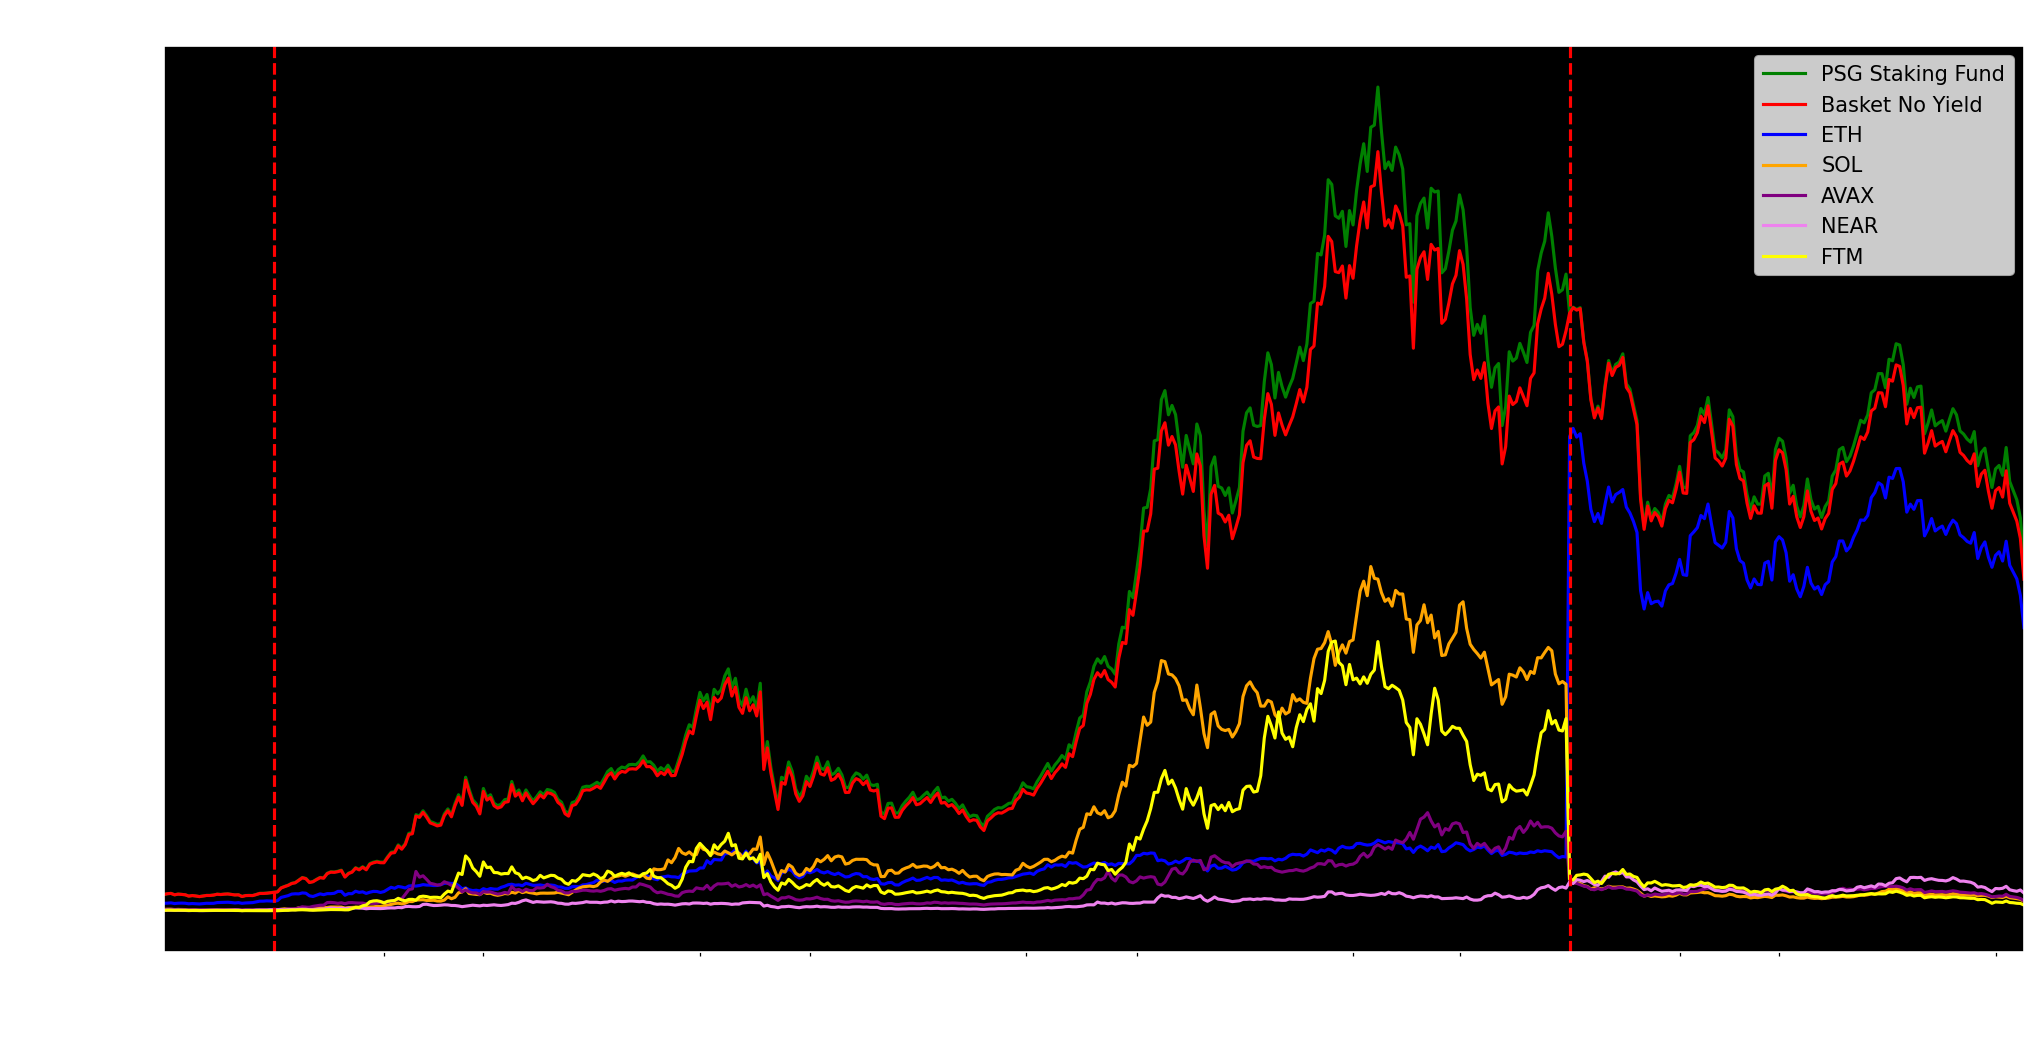

In [223]:
plt.figure(figsize=(16, 8), dpi=150)
ax = plt.axes()

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor("black");

plot_df = pd.DataFrame(columns =['Date','Basket No Yield','PSG Staking Fund','BTC Performance','ETH Performance','AVAX Performance'])


combined_basket_df['PSG Staking Fund'] = combined_staking_basket_df['basket_staking_nav']
combined_basket_df['Basket No Yield'] = combined_basket_df['BASKET_NET']
#combined_basket_df['BTC Performance'] = basket_portfolio_df['BTC_NET']
combined_basket_df['ETH Performance'] = combined_basket_df['ETH_NET']
combined_basket_df['SOL Performance'] = combined_basket_df['SOL_NET']
combined_basket_df['AVAX Performance'] = combined_basket_df['AVAX_NET']
combined_basket_df['NEAR Performance'] = combined_basket_df['NEAR_NET']
combined_basket_df['FTM Performance'] = combined_basket_df['FTM_NET']

plot_df.set_index('Date',inplace=True)
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
combined_basket_df['PSG Staking Fund'].plot(label='PSG Staking Fund', color='green')
combined_basket_df['Basket No Yield'].plot(label='Basket No Yield', color='red')
combined_basket_df['ETH Performance'].plot(label='ETH', color='blue')
combined_basket_df['SOL Performance'].plot(label='SOL', color='orange')
combined_basket_df['AVAX Performance'].plot(label='AVAX', color='purple')
combined_basket_df['NEAR Performance'].plot(label='NEAR', color='violet')
combined_basket_df['FTM Performance'].plot(label='FTM', color='yellow')
#compare_df['21Shares HODL ETP'].plot(label='21Shares HODL ETP', color='red')
#compare_df['PSG Staking Fund'].plot(label='PSG Staking Fund', color='green')
  
# adding title to the plot
plt.title('2 Year Comparison Over 21 Shares ETP Performance',color="white")
  
# adding Label to the x-axis
plt.xlabel('Time Over 2 Years',color='white')
plt.ylabel('Amount in $',color='white')

current_values = ax.get_yticks()
# # using format string '{:.0f}' here but you can choose others
ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

#plot vertical line
plt.axvline(x='2022-01-01', color='red', linestyle='--')
#plot vertical line
plt.axvline(x='2021-01-01', color='red', linestyle='--')
# adding legend to the curve
plt.legend()

In [ ]:
# timing of rebalancing
# effect of APY